## References

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\enlik\Miniconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\enlik\Miniconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=T

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [10]:
id2word[0]

'addition'

In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.175*"file" + 0.073*"entry" + 0.057*"error" + 0.053*"display" + '
  '0.040*"program" + 0.030*"sun" + 0.025*"version" + 0.024*"cool" + '
  '0.020*"output" + 0.020*"crash"'),
 (1,
  '0.032*"would" + 0.026*"say" + 0.022*"think" + 0.022*"people" + 0.020*"go" + '
  '0.018*"know" + 0.016*"make" + 0.016*"see" + 0.014*"come" + 0.013*"thing"'),
 (2,
  '0.091*"evidence" + 0.048*"book" + 0.041*"faith" + 0.037*"reason" + '
  '0.033*"exist" + 0.032*"claim" + 0.031*"religion" + 0.029*"believe" + '
  '0.027*"christian" + 0.023*"church"'),
 (3,
  '0.541*"ax" + 0.054*"car" + 0.028*"player" + 0.014*"engine" + 0.009*"dealer" '
  '+ 0.009*"mile" + 0.009*"expensive" + 0.009*"here" + 0.008*"extra" + '
  '0.008*"specify"'),
 (4,
  '0.087*"belief" + 0.084*"internet" + 0.079*"atheist" + 0.061*"distribution" '
  '+ 0.053*"wing" + 0.041*"atheism" + 0.038*"printer" + 0.034*"interface" + '
  '0.026*"multiple" + 0.020*"thinking"'),
 (5,
  '0.088*"normal" + 0.072*"port" + 0.071*"mouse" + 0.053*"hole" + 0.03

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -12.486502756631147

Coherence Score:  0.49288861569721343


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\enlik\Miniconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.335627 -0.217746       1        1  28.085324
18    -0.302093 -0.145059       2        1  18.153931
9     -0.271870 -0.004533       3        1  15.586814
19    -0.213917  0.101540       4        1   8.162795
3      0.014729  0.121685       5        1   5.748542
10    -0.144864  0.268438       6        1   5.679871
6     -0.129654  0.185646       7        1   5.134119
2     -0.061843 -0.076504       8        1   2.129786
14    -0.018008 -0.093225       9        1   1.930819
16     0.000206  0.059324      10        1   1.922142
11     0.069657  0.074444      11        1   1.423864
0      0.119144  0.020979      12        1   1.152384
12     0.109095 -0.008047      13        1   1.039407
8      0.085481 -0.055228      14        1   0.971927
7      0.131145 -0.010046      15        1   0.884548
4      0.160738 -0.037305      16        1   0.697291
13     0.172285 -0.042792      17        1   0.449755
15     0.198402 -0.044230      18        1   0.375347
5      0.200337 -0.048561      19        1   0.334446
17     0.216654 -0.048779      20        1   0.136887, topic_info=              Term          Freq         Total Category  logprob  loglift
3718            ax  36366.000000  36366.000000  Default  30.0000  30.0000
18            line  15682.000000  15682.000000  Default  29.0000  29.0000
197          write  13139.000000  13139.000000  Default  28.0000  28.0000
39            year   4567.000000   4567.000000  Default  27.0000  27.0000
140         people   7716.000000   7716.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
6226  redistribute      0.026008      1.250146  Topic20 -11.0266   2.7211
6951     judgement      0.026008      1.250164  Topic20 -11.0266   2.7211
9115      tomorrow      0.026008      1.250169  Topic20 -11.0266   2.7211
5664  announcement      0.026008      1.250197  Topic20 -11.0266   2.7211
4072          baby      0.026008      1.250174  Topic20 -11.0266   2.7211

[866 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1227      1  0.999081        accept
345      15  0.914020    acceptance
326      17  0.943326  accidentally
0         7  0.998126      addition
175       2  0.399800       address
...     ...       ...           ...
39        1  0.028244          year
39        3  0.824321          year
39       14  0.147349          year
722      13  0.992128     yesterday
570       1  0.998437         young

[1113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 10, 20, 4, 11, 7, 3, 15, 17, 12, 1, 13, 9, 8, 5, 14, 16, 6, 18])

In [18]:
# https://stackoverflow.com/questions/55288724/gensim-mallet-calledprocesserror-returned-non-zero-exit-status
# in Windows, make sure Java JDK was installed
# update mallet.bat file

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

# mallet_path = 'mallet-2.0.8/bin/mallet.bat' # update this path
mallet_path = 'C:/mallet-2.0.8/bin/mallet.bat'

# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

# result = (ldamallet.show_topics(num_topics=3, num_words=10,formatted=False))
# for each in result:
#     print(each)

In [19]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(2,
  [('write', 0.19245590230664858),
   ('line', 0.16824966078697423),
   ('article', 0.1221438263229308),
   ('nntp_poste', 0.08431478968792401),
   ('host', 0.08287652645861601),
   ('organization', 0.06388059701492538),
   ('reply', 0.02919945725915875),
   ('read', 0.012075983717774762),
   ('net', 0.008873812754409769),
   ('post', 0.007272727272727273)]),
 (0,
  [('game', 0.03138406430921738),
   ('team', 0.0283643633637386),
   ('year', 0.027885376317214376),
   ('play', 0.025323836894497898),
   ('player', 0.019867549668874173),
   ('good', 0.017410137864967305),
   ('win', 0.014681994252155441),
   ('season', 0.012536965304677412),
   ('hit', 0.010183681119580158),
   ('run', 0.010121204548294389)]),
 (11,
  [('power', 0.018954070929687306),
   ('line', 0.015498901749796392),
   ('current', 0.01159949653249093),
   ('work', 0.011574816752634566),
   ('ground', 0.010711024457661837),
   ('high', 0.009378316345418199),
   ('wire', 0.009082158987141835),
   ('water', 0.0081690

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [26]:
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


Wall time: 11min 2s


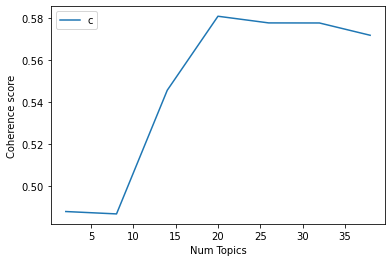

In [27]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.488
Num Topics = 8  has Coherence Value of 0.4868
Num Topics = 14  has Coherence Value of 0.5456
Num Topics = 20  has Coherence Value of 0.5808
Num Topics = 26  has Coherence Value of 0.5776
Num Topics = 32  has Coherence Value of 0.5776
Num Topics = 38  has Coherence Value of 0.5717


In [29]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.056*"people" + 0.019*"write" + 0.017*"make" + 0.013*"opinion" + '
  '0.013*"life" + 0.011*"man" + 0.010*"moral" + 0.009*"person" + 0.009*"world" '
  '+ 0.008*"drug"'),
 (1,
  '0.037*"car" + 0.012*"bike" + 0.011*"buy" + 0.010*"ride" + 0.009*"power" + '
  '0.008*"light" + 0.008*"engine" + 0.007*"side" + 0.007*"turn" + '
  '0.007*"water"'),
 (2,
  '0.011*"study" + 0.009*"food" + 0.008*"find" + 0.008*"effect" + '
  '0.008*"doctor" + 0.007*"day" + 0.007*"patient" + 0.007*"research" + '
  '0.007*"case" + 0.007*"problem"'),
 (3,
  '0.019*"people" + 0.015*"start" + 0.015*"happen" + 0.013*"day" + '
  '0.013*"leave" + 0.012*"time" + 0.012*"fire" + 0.010*"hear" + 0.010*"back" + '
  '0.009*"kill"'),
 (4,
  '0.013*"people" + 0.010*"attack" + 0.010*"israeli" + 0.010*"war" + '
  '0.009*"government" + 0.009*"armenian" + 0.009*"turkish" + 0.009*"land" + '
  '0.008*"kill" + 0.007*"today"'),
 (5,
  '0.025*"question" + 0.017*"exist" + 0.016*"point" + 0.016*"claim" + '
  '0.015*"true" + 0.014*"ar

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1518,"car, bike, buy, ride, power, light, engine, si...",From: (wheres my thing) Subject: WHAT car is t...
1,1,17.0,0.1629,"drive, card, problem, system, driver, work, bi...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,13.0,0.1402,"good, thing, time, make, problem, lot, bad, pr...",From: (Thomas E Willis) Subject: PB questions....
3,3,11.0,0.0879,"write, article, line, organization, read, hear...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,8.0,0.2285,"file, line, program, set, read, follow, change...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,18.0,0.3588,"gun, law, state, case, government, people, cri...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,2.0,0.1009,"study, food, find, effect, doctor, day, patien...",From: (brian manning delaney) Subject: Brain T...
7,7,17.0,0.4797,"drive, card, problem, system, driver, work, bi...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,14.0,0.0843,"window, image, application, program, display, ...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,17.0,0.1797,"drive, card, problem, system, driver, work, bi...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5540,"people, write, make, opinion, life, man, moral...",From: (Dan S.) Subject: Re: New Study Out On G...
1,1.0,0.5661,"car, bike, buy, ride, power, light, engine, si...",From: (richard welty) Subject: rec.autos: Freq...
2,2.0,0.6785,"study, food, find, effect, doctor, day, patien...",From: Subject: How To Prevent Kidney Stone For...
3,3.0,0.8236,"people, start, happen, day, leave, time, fire,...",From: (David Davidian) Subject: Accounts of An...
4,4.0,0.6895,"people, attack, israeli, war, government, arme...",From: Center for Policy Research Subject: Fina...


In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"car, bike, buy, ride, power, light, engine, si...",459.0,0.0406
1.0,17.0,"drive, card, problem, system, driver, work, bi...",1017.0,0.0899
2.0,13.0,"good, thing, time, make, problem, lot, bad, pr...",484.0,0.0428
3.0,11.0,"write, article, line, organization, read, hear...",314.0,0.0278
4.0,8.0,"file, line, program, set, read, follow, change...",475.0,0.0420
...,...,...,...,...
11309.0,2.0,"study, food, find, effect, doctor, day, patien...",NaN,NaN
11310.0,17.0,"drive, card, problem, system, driver, work, bi...",NaN,NaN
11311.0,17.0,"drive, card, problem, system, driver, work, bi...",NaN,NaN
11312.0,5.0,"question, exist, point, claim, true, argument,...",NaN,NaN
